# 0. Initialize

## 0.1. Import Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

## 0.2. DEFINE VARIABLES 

In [129]:
DATA_PATH = '/Users/gorkemyar/Desktop/CS412/'

ROUND = 3 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '27970'#'<insert-your-id-here>'
PROJECT_CODE = 'CS4123fa87858939a'#'<insert-your-code-here>' # Same code for the annotation eg. CS412xxxxx

## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [5]:
trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH),dtype={'tweet_id': str, 'isPolitical': str})
#trainingTweetDf = pd.read_csv('{}concatenated-training-tweet.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1597170281545551872,Yes
1,1431700027471192069,No
2,1566035577090281472,Yes
3,1591538690869940225,Yes
4,1583898169238167554,Yes
...,...,...
2995,1593539327623151619,Yes
2996,1393886554062524418,No
2997,1597925615092764672,Yes
2998,1585291418616176640,Yes


In [6]:
trainingTweetDf.isPolitical.value_counts()

Yes    2003
No      997
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [7]:
#trainingUserDf = pd.read_csv('{}concatenated-training-user.csv'.format(DATA_PATH))
trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf

,screen_name,isBot
0,koftecancaddy,No
1,ahaber,No
2,selahat03949652,No
3,erdin06357062,No
4,bhct__necatii,No
...,...,...
2995,djblumenberg,No
2996,mel1sq,No
2997,eren_yz1,Yes
2998,ergnyildiz4,No


In [8]:
trainingUserDf.isBot.value_counts()

No     2424
Yes     576
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [9]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/Annotation-CS412-202201/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/Annotation-CS412-202201/reports/report_CS4123fa87858939a.html


# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [10]:
PATH_TO_DOWNLOADED = DATA_PATH # 'D:/Users/suuser/Desktop/Sabancı/CS412/spring-2022/project/'

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [11]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [12]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [13]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [14]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [15]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [16]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']
    user_follower = tweet_metadata_line['user']['followers_count']
    user_total_tweet = tweet_metadata_line['user']['statuses_count']
    return id, screen_name, description, user_follower, user_total_tweet

#### 1.1.1.7 User name numeric characters

In [17]:
def numeric_character_count(text):
    return sum(c.isdigit() for c in text)

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [18]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['rterdogan', 'mansuryavas06', 'ekrem_imamoglu', 'dbdevletbahceli', 'meral_aksener', 'kilicdarogluk', 
                        'drfahrettinkoca', 'suleymansoylu', 'umitozdag', 'vekilince', 't_karamollaoglu', 'dogu_perincek', 
                        'vedatbilgn', 'ahmet_davutoglu', 'fuatoktay', 'fahrettinaltun', 'nureddinnebati', 'vahitkirisci', 
                        'akparti', '06melihgokcekvatan', 'türkiye', 'parti', 'bayrak', 'millet', 'CHP', 'AKP', 'iyi parti',
                        'demokrasi', 'devlet', 'meclispolitika', 'oy', 'seçim', 'cumhuriyet', 'adalet', 'ekonomi', 'sağlık', 
                        'eğitim', 'hak', 'dolar', 'atama', 'kadro', 'milletvekili', 'ülke', 'bakan', '06melihgokcek', 'tcbestepe', 
                        'varank', 'bekirpakdemirli', 'akaraismailoglu', 'alpayozalan35', 'kasapoglu', 'murat_kurum', 'tc_icisleri', 
                        'akkadinistanbul', 'herkesicinchp', 'ibbhabercomtr', 'mevlutcavusoglu', 'tcbuyuksehir', 'mhp_bilgi', 'deryayanikashb', 
                        'erkankandemir', 'ayyildirim1', 'rtedijital', 'azpresident', 'aysekesir', 'abdulhamitgul', 'gergerliogluof', 'tc_disisleri', 
                        'rbklndr', 'osmannnurika', 'mehmedmus', 'gazetesozcu', 'omerrcelik', 'e_semihyalcin', 'mehmetay01', 'fatmasahin', 'yildiraycicek9',
                        'csbgovtr', 'ahmetsceylan', 'tokcem', 'muratsahin2023', 'ziyaselcuk', 'fatih_donmez']
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [19]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

#### 1.1.2.3 Retweeted from a Politician

In [20]:
def is_retweeted_user_politician(username):
    
    political_figures = ['rterdogan', 'mansuryavas06', 'ekrem_imamoglu', 'dbdevletbahceli', 'meral_aksener', 'kilicdarogluk', 
                        'drfahrettinkoca', 'suleymansoylu', 'umitozdag', 'vekilince', 't_karamollaoglu', 'dogu_perincek', 
                        'vedatbilgn', 'ahmet_davutoglu', 'fuatoktay', 'fahrettinaltun', 'nureddinnebati', 'vahitkirisci', 
                        'akparti', '06melihgokcekvatan', 'türkiye', 'parti', 'bayrak', 'millet', 'CHP', 'AKP', 'iyi parti',
                        'allah', 'din', 'türk', 'demokrasi', 'devlet', 'meclispolitika', 'oy', 'seçim', 'cumhuriyet', 'adalet',
                        'haksızlık', 'ekonomi', 'sağlık', 'eğitim', 'hak', 'dolar', 'atama', 'kadro', 'milletvekili', 'ülke',
                        'bakan', '06melihgokcek', 'tcbestepe', 'varank', 'bekirpakdemirli', 'akaraismailoglu', 'alpayozalan35',
                        'kasapoglu', 'murat_kurum', 'tc_icisleri', 'akkadinistanbul', 'herkesicinchp', 'ibbhabercomtr', 'mevlutcavusoglu',
                        'tcbuyuksehir', 'mhp_bilgi', 'deryayanikashb', 'erkankandemir', 'ayyildirim1', 'rtedijital', 'azpresident',
                        'aysekesir', 'abdulhamitgul', 'gergerliogluof', 'tc_disisleri', 'rbklndr', 'osmannnurika', 'mehmedmus',
                        'gazetesozcu', 'omerrcelik', 'e_semihyalcin', 'mehmetay01', 'fatmasahin', 'yildiraycicek9', 'csbgovtr',
                        'ahmetsceylan', 'tokcem', 'muratsahin2023', 'ziyaselcuk', 'fatih_donmez']
    
    is_politician = 0;
    
    
    if ( username is not None and username.lower() in political_figures):
        is_politician = 1;
       
        
    return is_politician

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [21]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'is_retweeted_user_politician': [],
              'text':[],
              'text_length': [],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'user_tweet_count': [],
               'user_follower_count': [],
               'user_description_political':[],
              'num_political_entities':[],
              'total_interactions':[],
              'name_numeric_character_count':[]
              }


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    i = 0
    for line in f:
        
        i = i+1
        
        line = json.loads(line)
        
   
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description, user_follower, user_total_tweet = get_user_info(line)
        

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        description = line['user']['description']
        user_description_political = check_political_ent(description)
        total_num_interactions = total_interactions(retweet_count, favorite_count)
        retweeted_user_politician = is_retweeted_user_politician(retweeted_username)
        text_length = len(text)
        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['is_retweeted_user_politician'].append(retweeted_user_politician)
        dfPolitical['text'].append(text)
        dfPolitical['text_length'].append(text_length)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['user_follower_count'].append(user_follower)
        dfPolitical['user_tweet_count'].append(user_total_tweet)
        dfPolitical['user_description_political'].append(user_description_political)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['name_numeric_character_count'].append(numeric_character_count(screen_name))

In [22]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical


,tweet_id,is_retweet,retweeted_username,is_retweeted_user_politician,text,text_length,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,user_tweet_count,user_follower_count,user_description_political,num_political_entities,total_interactions,name_numeric_character_count
0,1588568792984346624,0,None,0,"Sosyal Hizmetin temelini çocuk oluşturur,çocuğ...",140,0,0,49,98,920963718103650304,maviruh_,shu/\nburaya afilli bir söz yazdığımı varsayın,2638,284,0,1,147,0
1,1588452263047069697,0,None,0,"@mahirunal Gavur İzmir ya onlar, hani Cumhuriy...",97,1,0,0,0,595514060,mtfdan,,6647,131,0,1,0,0
2,1569589330544398336,0,None,0,#ŞehitAdayıUzmÇvşaKadro\nSiz İstesenizde Istem...,140,0,1,0,0,1356375754561490947,ahsucilginuzman,Vatan Sevdalisi,2924,60,0,1,0,0
3,1570428119609139201,0,None,0,@ajans_muhbir Siz kaypak olmayıp onay vermesey...,140,1,0,0,0,1478775431008595968,hamitelkelle,HighOne,1783,2,0,0,0,0
4,1551163840368414722,0,None,0,Engelli öğretmenler olarak önümüzdeki engeller...,140,0,0,0,0,1511976696337113088,sed58417690,,7559,119,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33528,1568595408233832448,0,None,0,Gerçek kimlik taşımayan hesaplara cevap vermem...,140,0,0,9,81,576247173,ardanzenturk,RT ONAYLADIĞIM ANLAMINA GELMEZ\nArtık fikirler...,41342,171399,0,0,90,0
33529,1584027427696959488,0,None,0,@umitozdag Neden Suriyelilerle ilgili bu kadar...,140,1,0,1,8,162308585,ozgul_61,Bridge design engineer Yaay hesabı : dilfiruz,52340,3936,0,1,9,2
33530,1585945783307730945,0,None,0,@celebimehmeta Niye Türkiye yüzyılıda.Türkiye ...,76,1,0,0,1,415025519,ladrekova,,1225,121,0,2,1,0
33531,1569748909521801221,1,muazzezeralp,0,RT @muazzezeralp: @Doan58213655 @denizkonur @N...,140,7,1,6,0,1442125177727307781,yapikytgrivrlsn,,153819,591,0,2,6,0


## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.0 Average Tweets


##### 1.2.1.0.1 Format Month

In [59]:
def format_month(month):
  month = month.lower()
  if month == "jan":
      return 1
  elif month == "feb":
      return 2
  elif month == "mar":
      return 3     
  elif month == "apr":
      return 4     
  elif month == "may":
      return 5     
  elif month == "jun":
      return 6     
  elif month == "jul":
      return 7     
  elif month == "aug":
      return 8     
  elif month == "sep":
      return 9     
  elif month == "oct":
      return 10     
  elif month == "nov":
      return 11
  elif month == "dec":
      return 12
  else:
      return -1;

##### 1.2.1.0.2 Get Created Time


In [60]:
from datetime import date
def get_created_time(created_time_str):
  # format = Thu Oct 19 10:43:55 +0000 2017
  time_list = created_time_str.split(" ")
  year, month, day, time = time_list[-1], format_month(time_list[1]), time_list[2], time_list[3]
  time = time.split(":")
  hour, minute, seconds = time[0], time[1], time[2]
  datetime_object = date(int(year), int(month), int(day));
  return datetime_object


##### 1.2.1.0.3 Average Tweet Per Day

In [61]:
def average_time_per_day(created_at, tweet_count):
  created_date = get_created_time(created_at)
  today = date.today()
  day_count = (today - created_date).days
  average = tweet_count / day_count
  return average


#### 1.2.1.1. Get user info metadata

In [62]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']

    user_tweet_count = user_metadata_line['statuses_count']
    user_created_at = user_metadata_line['created_at']

    user_average_tweet_day = average_time_per_day(user_created_at, user_tweet_count)

    user_favourites_count = user_metadata_line['favourites_count']

    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count,
      'user_tweet_count': user_tweet_count, 'user_average_tweet_day':user_average_tweet_day, 'user_favourites_count': user_favourites_count}

      

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [63]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [64]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

In [65]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
         'user_tweet_count': [],
         'user_average_tweet_day': [],
         'user_favourites_count':[]}

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

In [66]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_tweet_count,user_average_tweet_day,user_favourites_count
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,2551,4.953398,17676
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,42771,49.446243,15474
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,14300,10.324910,18220
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,21303,8.347571,26999
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,1629,0.487579,2179
...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,2396,2.921951,10820
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,75178,15.867033,36671
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,6482,1.292265,7389
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,121113,37.403644,140095


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [67]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.2. Check median number of favorites

In [68]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

#### 1.2.2.3 Unique Tweet Ratio

In [69]:
def unique_tweets_ratio(line):
  if len(line['tweets']) == 0: 
    return 1
  tweets = set()
  for tweet in line['tweets']:
    if tweet['text'] not in tweets:
      tweets.add(tweet['text'])
  return len(tweets) / len(line['tweets'])

1.2.2.4 Mention Ratio

In [70]:
def mention_hashtag_ratio(line):
  if len(line['tweets']) == 0: 
    return 0, 0, 0
  tweets = set()
  mention = 0
  hashtag = 0
  tweet_len = 0
  for tweet in line['tweets']:
    tweet_len += len(tweet['text'])
    mention += tweet['text'].count('@')
    hashtag += tweet['text'].count('#')
  return mention / len(line['tweets']), hashtag / len(line['tweets']), tweet_len / len(line['tweets'])

#### 1.2.2.5 Retweeted from Unique Users Ratio

In [71]:
def retweet_unique_user_ratio(line):
    if len(line['tweets']) == 0: 
        return 1
    users = set()
    retweets = 0
    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            retweets += 1
            users.add(tweet['retweeted_status']['user']['screen_name'].lower())
        except:
            pass
    if len(users) == 0:
        return 1
    return retweets / len(users)

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [72]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[],
               'unique_tweet_ratio':[],
               'mention_ratio':[],
               'hashtag_ratio':[],
               'retweet_unique_user_ratio':[],
                'tweet_len_ratio':[]
              }

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:
        
        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)
        
        dfBotTweets['num_of_tweets'].append(len(line['tweets']))
  
        dfBotTweets['unique_tweet_ratio'].append(unique_tweets_ratio(line))
        
        mention_ratio, hashtag_ratio, tweet_len_ratio = mention_hashtag_ratio(line)
        dfBotTweets['mention_ratio'].append(mention_ratio)
        dfBotTweets['hashtag_ratio'].append(hashtag_ratio)
        dfBotTweets['tweet_len_ratio'].append(tweet_len_ratio)
        dfBotTweets['retweet_unique_user_ratio'].append(retweet_unique_user_ratio(line))

        i += 1
        if i % 1000 == 0:
            print(i)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [73]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets,unique_tweet_ratio,mention_ratio,hashtag_ratio,retweet_unique_user_ratio,tweet_len_ratio
0,594642154,0.115000,2.0,200,1.000000,0.745000,0.005000,1.095238,87.340000
1,525600289,0.005025,1.0,199,0.984925,1.115578,0.100503,1.000000,49.351759
2,931895965501534209,0.900000,0.0,200,0.875000,2.080000,0.870000,2.432432,132.025000
3,1591543462746329088,0.185000,0.0,200,0.995000,2.350000,0.065000,2.466667,119.200000
4,734801354749796352,1.000000,0.0,200,1.000000,1.060000,0.115000,1.801802,122.155000
...,...,...,...,...,...,...,...,...,...
28310,1591370361488252928,0.800000,0.0,200,0.975000,1.455000,0.515000,3.076923,128.135000
28311,1475272459616235525,0.825000,0.0,200,1.000000,2.075000,0.230000,1.352459,119.580000
28312,1096753792731750401,0.051020,1.0,196,1.000000,0.969388,0.020408,1.428571,69.673469
28313,1269527617687953409,0.095000,2.0,200,1.000000,0.340000,0.005000,1.055556,51.130000


### 1.2.3. Merge dfBot and dfBotTweets

In [74]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')


print(dfBotAll.isna().sum())
#dfBotAll[['retweet_total_ratio', 'num_median_favorites', 'hashtag_ratio', 'tweet_len_ratio', 'unique_tweet_ratio']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites','hashtag_ratio', 'tweet_len_ratio', 'unique_tweet_ratio']].fillna(0)
print(dfBotAll.shape)
dfBotAll

user_id                         0
user_name                       0
user_screen_name                0
user_location                   0
user_description                0
user_followers_count            0
user_friends_count              0
description_len                 0
followers_to_all_ratio          0
user_tweet_count                0
user_average_tweet_day          0
user_favourites_count           0
retweet_total_ratio          1438
num_median_favorites         1438
num_of_tweets                1355
unique_tweet_ratio           1355
mention_ratio                1355
hashtag_ratio                1355
retweet_unique_user_ratio    1355
tweet_len_ratio              1355
dtype: int64
(29670, 20)


,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_tweet_count,user_average_tweet_day,user_favourites_count,retweet_total_ratio,num_median_favorites,num_of_tweets,unique_tweet_ratio,mention_ratio,hashtag_ratio,retweet_unique_user_ratio,tweet_len_ratio
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,2551,4.953398,17676,0.395939,0.0,197.0,1.000000,1.274112,0.096447,1.471698,72.126904
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,42771,49.446243,15474,0.125000,0.0,200.0,1.000000,0.840000,0.000000,1.190476,39.605000
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,14300,10.324910,18220,0.910000,0.0,200.0,0.995000,2.750000,1.240000,3.956522,121.570000
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,21303,8.347571,26999,0.015306,1.0,196.0,1.000000,0.290816,0.010204,1.000000,83.020408
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,1629,0.487579,2179,0.659898,0.0,197.0,1.000000,0.923858,0.446701,1.625000,119.421320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,2396,2.921951,10820,0.015000,1.0,200.0,0.995000,1.225000,0.040000,1.500000,70.435000
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,75178,15.867033,36671,0.291457,2.0,199.0,0.994975,0.778894,0.085427,1.260870,88.246231
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,6482,1.292265,7389,0.061538,0.0,195.0,1.000000,1.148718,0.051282,1.000000,42.805128
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,121113,37.403644,140095,0.995000,0.0,200.0,1.000000,1.090000,0.045000,3.209677,129.175000


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [130]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head(30)


,tweet_id,is_retweet,retweeted_username,is_retweeted_user_politician,text,text_length,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,user_tweet_count,user_follower_count,user_description_political,num_political_entities,total_interactions,name_numeric_character_count,isPolitical
0,1585955683513798656,0,None,0,@AvOzlemZengin YüzüncüYıla YakışanGenelAf adli...,126,1,0,3,2,1564992353168941058,zehra78231638,,25730,221,0,0,5,8,Yes
1,1597631718479261696,0,None,0,#TCYüzyılıÜcretliÖgrtKadro\n#TCYüzyılıÜcretliÖ...,140,0,2,30,28,1324630334416297985,nurozguler,,12427,455,0,1,58,0,Yes
2,1572522789948751874,0,None,0,Ekrem İmamoğlu davayı değerlendirdi. 'Boş işle...,131,0,0,5,66,407597071,onediocom,Türkiye'nin ilk ve tek sosyal içerik sitesi ht...,161123,735643,1,0,71,0,Yes
3,1591412481561624577,0,None,0,Sayın Bakanım @suleymansoylu POMEM önlisans er...,140,1,0,0,0,1394789887073738753,buckybarnestr,...,1595,10,0,3,0,0,Yes
4,1596914274907348992,0,None,0,"@varank Sayın bakanım, Bodrumdaki bu araziyi ...",87,1,0,0,0,1586083256088371201,sayariahmet,,1251,6,0,2,0,0,Yes
5,1597147910184968192,0,None,0,"@drfahrettinkoca Üniversite sınavında, KPSS de...",140,1,0,1,3,1595686009416605697,dytmyt2,Diyetisyen Etkinlik Hesabı,5391,174,0,1,4,1,Yes
6,1596356027129401344,0,None,0,@HaberturkTV @filaligs1905 @ProfDrErsanSen Eğe...,140,3,0,0,2,3605839396,2121elyas,Allah bizi hak yolundan ayırmasın. Batıldan uz...,3296,110,1,0,2,4,Yes
7,1407916468230967299,0,None,0,@bIuemarinewes 40k yu sini https://t.co/YRvYTh...,50,0,0,0,0,1398300266185695232,ad3www,akun ba berubah jadi akun pejuang GA,5763,48,0,0,0,1,No
8,1592261577381756935,0,None,0,@dfikrisaglar Bıkmadın değilmi yalanlara,40,1,0,0,1,1558508220062306304,tulga343434,,2123,83,0,0,1,6,Yes
9,1597125142119059456,0,None,0,"@alikenanoglu ... devri daim olsun, yıldızlar ...",60,1,0,0,0,141573197,camurdan_,"#sociology, #hamdolsunülkesi nde sıradan yaşam...",10133,163,2,0,0,0,No


#### 2.1.1.5 Processing Text Columns to Embeddings

In [131]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

text  = dfPoliticalAll_train.apply(lambda x: x[['text']], axis=1)
description = dfPoliticalAll_train.apply(lambda x: x[['user_description']], axis=1)

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

# Compute embeddings.
text_result = embed(text)
description_result = embed(description)


In [25]:
print(text_result.shape)
print(description_result.shape)

(3000, 512)
(3000, 512)


In [26]:
text_result[0][0].numpy()

-0.08994086

### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [132]:
X = dfPoliticalAll_train[['text_length','num_mentions', 'user_description_political','num_political_entities'
                        ,'num_hashtags',  'total_interactions', 'name_numeric_character_count']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

X.head(10)



,text_length,num_mentions,user_description_political,num_political_entities,num_hashtags,total_interactions,name_numeric_character_count
0,126,1,0,0,0,5,8
1,140,0,0,1,2,58,0
2,131,0,1,0,0,71,0
3,140,1,0,3,0,0,0
4,87,1,0,2,0,0,0
5,140,1,0,1,0,4,1
6,140,3,1,0,0,2,4
7,50,0,0,0,0,0,1
8,40,1,0,0,0,1,6
9,60,1,2,0,0,0,0


In [29]:
def createDict(char,text_fields):
    text_map = dict()
    for i in range(len(text_fields[0])):
        text_map[char+ '_' + str(i)] = []
    for i in range(len(text_fields)):
        if (i % 100 == 0):
            print(i)
        for j in range(len(text_fields[i])):
            text_map[char+'_' + str(j)].append(text_fields[i][j].numpy())
    return text_map

In [30]:
text_dict = createDict("t",text_result)
#description_dict = createDict("d",description_result)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [133]:
df_text = pd.DataFrame(text_dict)
#df_description = pd.DataFrame(description_dict)
X = X.join(df_text)
#X = X.join(df_description)
X.head(10)

,text_length,num_mentions,user_description_political,num_political_entities,num_hashtags,total_interactions,name_numeric_character_count,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,t_40,t_41,t_42,t_43,t_44,t_45,t_46,t_47,t_48,t_49,t_50,t_51,t_52,t_53,t_54,t_55,t_56,t_57,t_58,t_59,t_60,t_61,t_62,t_63,t_64,t_65,t_66,t_67,t_68,t_69,t_70,t_71,t_72,t_73,t_74,t_75,t_76,t_77,t_78,t_79,t_80,t_81,t_82,t_83,t_84,t_85,t_86,t_87,t_88,t_89,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,t_100,t_101,t_102,t_103,t_104,t_105,t_106,t_107,t_108,t_109,t_110,t_111,t_112,t_113,t_114,t_115,t_116,t_117,t_118,t_119,t_120,t_121,t_122,t_123,t_124,t_125,t_126,t_127,t_128,t_129,t_130,t_131,t_132,t_133,t_134,t_135,t_136,t_137,t_138,t_139,t_140,t_141,t_142,t_143,t_144,t_145,t_146,t_147,t_148,t_149,t_150,t_151,t_152,t_153,t_154,t_155,t_156,t_157,t_158,t_159,t_160,t_161,t_162,t_163,t_164,t_165,t_166,t_167,t_168,t_169,t_170,t_171,t_172,t_173,t_174,t_175,t_176,t_177,t_178,t_179,t_180,t_181,t_182,t_183,t_184,t_185,t_186,t_187,t_188,t_189,t_190,t_191,t_192,t_193,t_194,t_195,t_196,t_197,t_198,t_199,t_200,t_201,t_202,t_203,t_204,t_205,t_206,t_207,t_208,t_209,t_210,t_211,t_212,t_213,t_214,t_215,t_216,t_217,t_218,t_219,t_220,t_221,t_222,t_223,t_224,t_225,t_226,t_227,t_228,t_229,t_230,t_231,t_232,t_233,t_234,t_235,t_236,t_237,t_238,t_239,t_240,t_241,t_242,t_243,t_244,t_245,t_246,t_247,t_248,t_249,t_250,t_251,t_252,t_253,t_254,t_255,t_256,t_257,t_258,t_259,t_260,t_261,t_262,t_263,t_264,t_265,t_266,t_267,t_268,t_269,t_270,t_271,t_272,t_273,t_274,t_275,t_276,t_277,t_278,t_279,t_280,t_281,t_282,t_283,t_284,t_285,t_286,t_287,t_288,t_289,t_290,t_291,t_292,t_293,t_294,t_295,t_296,t_297,t_298,t_299,t_300,t_301,t_302,t_303,t_304,t_305,t_306,t_307,t_308,t_309,t_310,t_311,t_312,t_313,t_314,t_315,t_316,t_317,t_318,t_319,t_320,t_321,t_322,t_323,t_324,t_325,t_326,t_327,t_328,t_329,t_330,t_331,t_332,t_333,t_334,t_335,t_336,t_337,t_338,t_339,t_340,t_341,t_342,t_343,t_344,t_345,t_346,t_347,t_348,t_349,t_350,t_351,t_352,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392,t_393,t_394,t_395,t_396,t_397,t_398,t_399,t_400,t_401,t_402,t_403,t_404,t_405,t_406,t_407,t_408,t_409,t_410,t_411,t_412,t_413,t_414,t_415,t_416,t_417,t_418,t_419,t_420,t_421,t_422,t_423,t_424,t_425,t_426,t_427,t_428,t_429,t_430,t_431,t_432,t_433,t_434,t_435,t_436,t_437,t_438,t_439,t_440,t_441,t_442,t_443,t_444,t_445,t_446,t_447,t_448,t_449,t_450,t_451,t_452,t_453,t_454,t_455,t_456,t_457,t_458,t_459,t_460,t_461,t_462,t_463,t_464,t_465,t_466,t_467,t_468,t_469,t_470,t_471,t_472,t_473,t_474,t_475,t_476,t_477,t_478,t_479,t_480,t_481,t_482,t_483,t_484,t_485,t_486,t_487,t_488,t_489,t_490,t_491,t_492,t_493,t_494,t_495,t_496,t_497,t_498,t_499,t_500,t_501,t_502,t_503,t_504,t_505,t_506,t_507,t_508,t_509,t_510,t_511
0,126,1,0,0,0,5,8,-0.089941,-0.075957,0.018150,-0.108695,0.027636,0.012923,0.021453,0.005041,-0.001704,0.033507,0.051860,0.061770,0.060722,-0.053460,-0.062884,0.042074,0.013057,0.043430,0.071359,-0.119902,0.016824,-0.019438,-0.078844,0.014011,0.057227,0.007639,0.048322,-0.020166,-0.025848,-0.012840,-0.056167,0.013752,0.053422,-0.017923,-0.016819,0.007216,0.046906,-0.027125,-0.031892,-0.044095,0.042979,0.029726,0.101065,-0.013388,0.019549,-0.056209,0.086504,-0.074706,-0.044723,0.026946,-0.064658,-0.050003,-0.056228,0.041210,0.023656,-0.005177,0.060323,-0.047386,0.052220,0.042694,-0.046308,0.032248,0.056457,-0.033002,-0.075927,0.035111,0.015337,-0.031113,0.019626,-0.020950,0.045575,-0.049889,0.022302,-0.065923,0.004314,-0.003472,-0.001789,-0.064423,0.103106,-0.048736,-0.123228,0.121773,-0.017553,0.055981,0.060865,-0.000167,-0.084444,0.024398,-0.052896,-0.037500,0.084469,0.041199,-0.068945,-

#### 2.1.2.0 Oversampling

In [134]:
print("Before OverSampling, counts of label '1': {}".format(sum( y== 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X, y.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))

Before OverSampling, counts of label '1': 2003
Before OverSampling, counts of label '0': 997 

After OverSampling, the shape of train_X: (4006, 519)
After OverSampling, the shape of train_y: (4006,) 

After OverSampling, counts of label '1': 2003
After OverSampling, counts of label '0': 2003


### 2.1.3. Train - validation split

In [135]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.20, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42) 

In [136]:
print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(3204, 519) (3204,)
(802, 519) (802,)


#### 2.1.3.0 Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# import xgboost as xgb
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 5, 7, 10, 12,15],
#         'min_child_weight': [1, 3, 5, 7],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.3,0.4, 0.5, 0.7],
#         'n_estimators' : [100],
#         'objective': ['reg:squarederror']
#     }

#     xgb_model = xgb.XGBClassifier()

#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            #scoring = 'neg_mean_absolute_error', #MAE
#                            scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

#     gsearch.fit(X_train,y_train)
#     return gsearch.best_params_
# best_params = hyperParameterTuning(X_train,y_train)
# print(best_params)

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

#### 2.1.4.1. XGBOOST Model

In [137]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns
# {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
xg_political = xgb.XGBClassifier(learning_rate=0.01,
                          max_depth=7,
                          colsample_bytree= 0.5,
                          min_child_weight= 7,
                          subsample= 0.7,
                          objective="reg:squarederror",
                          n_estimators=100)

xg_political.fit(X_train, y_train)

y_pred = xg_political.predict(X_valid)
#y_pred_test = xg_political.predict(X_test)

print("MSE: ", mean_squared_error(y_valid, y_pred))


MSE:  0.16209476309226933


#### 2.1.4.2 ADABOOST Model

In [138]:
#### ADABOOST ####
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
# Create the base model
base_model_1 = DecisionTreeRegressor()
base_model_2 = LinearRegression()
base_model_3 = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
base_model_4 = SVR()


# Create the ensemble model
ensemble_model_political = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42, loss="linear")

# Fit the ensemble model to the training data
ensemble_model_political.fit(X_train, y_train)

# Predict using the ensemble model on the test data
y_pred = ensemble_model_political.predict(X_valid)
y_pred = [0 if x < 0 else x for x in y_pred]
y_pred = [1 if x > 1 else x for x in y_pred]

# Evaluate the ensemble model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_valid, y_pred)

print("Mean Squared Error: {:.4f}".format(mse))


Mean Squared Error: 0.1482


In [37]:
print(X_train.shape)

(3204, 519)


#### 2.1.4.3 NN Model

In [159]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


##### This code segment getted from https://stackoverflow.com/questions/48285129/saving-best-model-in-keras
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('political_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_political = Sequential()
model_political.add(Dense(32, activation='relu'))
model_political.add(Dropout(0.2))
model_political.add(Dense(16, activation='relu'))
model_political.add(Dropout(0.2))
model_political.add(Dense(8, activation='relu'))
model_political.add(Dropout(0.2))
model_political.add(Dense(1, activation='sigmoid'))
model_political.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error']
               )
history = model_political.fit(X_train, y_train,
            epochs=100,
            batch_size=8,
            validation_data=(X_valid, y_valid),
            verbose=0,
            callbacks=[earlyStopping, mcp_save,reduce_lr_loss],
            )

#score = model_political.evaluate(X_valid, y_valid, batch_size=64)


Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [160]:
model_political.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 32)                16640     
                                                                 
 dropout_34 (Dropout)        (None, 32)                0         
                                                                 
 dense_49 (Dense)            (None, 16)                528       
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_50 (Dense)            (None, 8)                 136       
                                                                 
 dropout_36 (Dropout)        (None, 8)                 0         
                                                                 
 dense_51 (Dense)            (None, 1)               

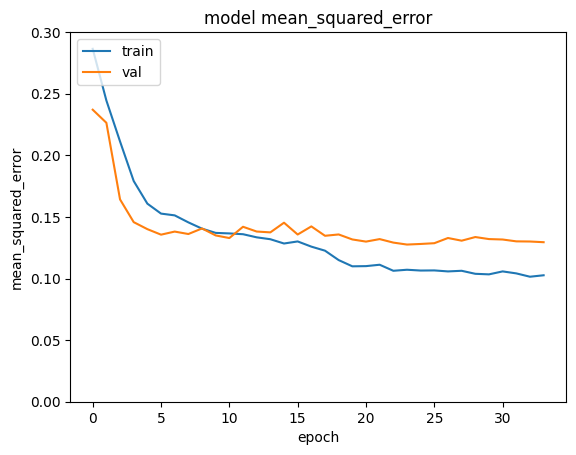

In [161]:
from matplotlib import pyplot as plt
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.ylim(0, 0.3)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [162]:
model_political.load_weights(filepath = 'political_best.hdf5')
y_res = model_political.predict(X_valid)
y_res = [0 if x < 0 else x for x in y_res]
y_res = [1 if x > 1 else x for x in y_res]

score = mean_squared_error(y_valid, y_res)

#print(y_res)
#0.12134737364230679
'''
model_political.add(Dense(16, activation='relu'))
model_political.add(Dropout(0.1))
model_political.add(Dense(8, activation='relu'))
model_political.add(Dropout(0.1))
model_political.add(Dense(1, activation='sigmoid'))
model_political.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error']
               )
'''
print(score)

26/26 [==============================] - 0s 2ms/step
0.12757084001405644


#### Logistic Regression Model

In [163]:
from sklearn.linear_model import LogisticRegression

lr_bot = LogisticRegression()
lr_bot.fit(X_train, y_train)
y_pred_LR = lr_bot.predict(X_valid)


from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns

print("MSE VALID: ", mean_squared_error(y_valid, y_pred))


MSE VALID:  0.14819665995939696


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [164]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [165]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')
dfBotAll_train.head(5)

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_tweet_count,user_average_tweet_day,user_favourites_count,retweet_total_ratio,num_median_favorites,num_of_tweets,unique_tweet_ratio,mention_ratio,hashtag_ratio,retweet_unique_user_ratio,tweet_len_ratio,screen_name,isBot
0,1512081815292432394,sezgin,sezgin953116371,,,46,430,0,0.096639,1535,5.256849,9627,0.050251,0.0,199.0,1.000000,1.507538,0.010050,1.000000,71.663317,sezgin953116371,No
1,1425452291428077571,Adem Koç,gogoadem61,,,14,171,0,0.075676,113,0.212806,74,0.761062,0.0,113.0,1.000000,1.371681,0.619469,1.653846,101.654867,gogoadem61,No
2,328164303,Necmettin Balıkçı,dewil511,,,21,49,0,0.300000,219,0.051847,25,0.010101,0.0,198.0,0.929293,0.272727,0.646465,1.000000,63.111111,dewil511,Yes
3,1343666971368431622,Night Bird⁷🦉,midnight__bird,,"La vie est un sommeil, l’amour en est le rêve...",422,260,48,0.618768,15191,20.067371,84933,0.085000,1.0,200.0,1.000000,0.820000,0.055000,2.125000,82.240000,midnight__bird,No
4,1240932880488038400,Samed Pınarcı,samedpinarci,,Orman Mühendisi - Orman İşletme Şefi - Orman G...,133,202,60,0.397015,3734,3.590385,15783,0.780000,0.0,200.0,1.000000,0.855000,0.300000,2.689655,123.430000,samedpinarci,No


In [166]:
trainingUserDf.isBot.value_counts()

No     2424
Yes     576
Name: isBot, dtype: int64

#### 2.2.1.1 Processing Text Columns to Embeddings

In [104]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

screen_name  = dfBotAll_train.apply(lambda x: x[['user_screen_name']], axis=1)
description = dfBotAll_train.apply(lambda x: x[['user_description']], axis=1)

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

# Compute embeddings.
screen_name_result = embed(screen_name)
description_result = embed(description)

In [105]:
print(screen_name_result.shape)
print(description_result.shape)

(3000, 512)
(3000, 512)


### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [167]:
X = dfBotAll_train[['retweet_total_ratio',  'user_average_tweet_day', 'user_tweet_count',
                    'unique_tweet_ratio', 'user_followers_count', 'user_friends_count', 
                    'hashtag_ratio',  'tweet_len_ratio']]
y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

In [168]:
X.head(5)

,retweet_total_ratio,user_average_tweet_day,user_tweet_count,unique_tweet_ratio,user_followers_count,user_friends_count,hashtag_ratio,tweet_len_ratio
0,0.050251,5.256849,1535,1.000000,46,430,0.010050,71.663317
1,0.761062,0.212806,113,1.000000,14,171,0.619469,101.654867
2,0.010101,0.051847,219,0.929293,21,49,0.646465,63.111111
3,0.085000,20.067371,15191,1.000000,422,260,0.055000,82.240000
4,0.780000,3.590385,3734,1.000000,133,202,0.300000,123.430000


In [102]:
def createDict(char,text_fields):
    text_map = dict()
    for i in range(len(text_fields[0])):
        text_map[char+ '_' + str(i)] = []
    for i in range(len(text_fields)):
        if (i % 100 == 0):
            print(i)
        for j in range(len(text_fields[i])):
            text_map[char+'_' + str(j)].append(text_fields[i][j].numpy())
    return text_map

In [108]:
#screen_name_dict = createDict("t",screen_name_result)
description_dict = createDict("d",description_result)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [169]:
#df_screen_name = pd.DataFrame(screen_name_dict)
df_description = pd.DataFrame(description_dict)
#X = X.join(df_screen_name)
X = X.join(df_description)
X.head(20)

,retweet_total_ratio,user_average_tweet_day,user_tweet_count,unique_tweet_ratio,user_followers_count,user_friends_count,hashtag_ratio,tweet_len_ratio,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511
0,0.050251,5.256849,1535,1.000000,46,430,0.010050,71.663317,0.113856,0.034398,-0.006175,0.004900,-0.022477,0.018768,0.031511,0.046432,-0.002459,-0.002604,-0.009886,-0.038638,0.080208,-0.042361,-0.087995,-0.050095,0.015845,0.107457,0.030547,0.091331,-0.033574,0.113801,0.046039,-0.014919,0.067701,-0.016054,0.050952,-0.051625,-0.025408,0.005544,0.029900,0.035108,0.057384,-0.035775,0.002374,-0.081888,-0.018261,-0.016812,0.028970,-0.053918,0.044287,-0.048315,-0.039557,-0.053663,0.016992,0.073504,0.046018,0.008314,0.034484,0.015027,0.056787,-0.031160,0.034105,-0.048177,-0.020239,-0.113848,-0.027957,0.070973,0.067590,0.008107,0.030899,0.012379,-0.019263,0.011931,-0.032174,0.005612,0.020298,-0.002306,-0.027958,0.033474,0.026377,0.008586,-0.011282,-0.022333,-0.037147,0.048300,0.029022,0.010195,0.025284,0.109023,-0.112168,-0.023279,-0.019458,-0.028097,-0.003214,-0.017228,-0.086662,0.01

In [170]:
X.isna().sum()

retweet_total_ratio       73
user_average_tweet_day     0
user_tweet_count           0
unique_tweet_ratio        63
user_followers_count       0
                          ..
d_507                      0
d_508                      0
d_509                      0
d_510                      0
d_511                      0
Length: 520, dtype: int64

In [171]:
for col in X.columns:
    X[col] = X[col].fillna(X[col].mean())


#### Oversampling

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum( y== 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X, y.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))

### 2.2.3. Train-test split

In [172]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.2.4. Train the model

#### 2.2.4.1 Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# import xgboost as xgb
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 5, 7, 10, 12,15],
#         'min_child_weight': [1, 3, 5, 7],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.3,0.4, 0.5, 0.7],
#         'n_estimators' : [100],
#         'objective': ['reg:squarederror']
#     }

#     xgb_model = xgb.XGBClassifier()

#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            #scoring = 'neg_mean_absolute_error', #MAE
#                            scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

#     gsearch.fit(X_train,y_train)
#     return gsearch.best_params_
# best_params = hyperParameterTuning(X_train,y_train)
# print(best_params)

#### 2.2.4.2 Train Model

##### 2.2.4.2.1 ADABOOST

In [173]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR


ensemble_model_bot = AdaBoostRegressor(n_estimators=100, learning_rate=0.005, random_state=42, loss="square")
ensemble_model_bot.fit(X_train, y_train)

y_pred = ensemble_model_bot.predict(X_valid)
y_pred = [0 if x < 0 else x for x in y_pred]
y_pred = [1 if x > 1 else x for x in y_pred]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error: {:.4f}".format(mse))


Mean Squared Error: 0.1112


##### 2.2.4.2.2 LinearRegression Model

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

lr_bot = LinearRegression()
lr_bot.fit(X_train, y_train)
y_pred_LR = lr_bot.predict(X_valid)

y_pred_train_LR = lr_bot.predict(X_train)

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns

#print(y_pred_LR)
y_pred_LR = [0 if x < 0 else x for x in y_pred_LR]
y_pred_LR = [1 if x > 1 else x for x in y_pred_LR]

print("MSE VALID: ", mean_squared_error(y_valid, y_pred_LR))


MSE VALID:  0.1229116310565621


##### 2.2.4.2.3 NN Model

In [120]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

##### This code segment getted from https://stackoverflow.com/questions/48285129/saving-best-model-in-keras
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('bot_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_bot = Sequential()

model_bot.add(Dense(32, activation='relu'))
model_bot.add(Dropout(0.1))
model_bot.add(Dense(16, activation='relu'))
model_bot.add(Dropout(0.1))
model_bot.add(Dense(8, activation='relu'))
model_bot.add(Dense(1, activation='sigmoid'))
model_bot.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error']
               )
history = model_bot.fit(X_train, y_train,
            epochs=100,
            batch_size=8,
            validation_data=(X_valid, y_valid),
            verbose=0,
            callbacks=[earlyStopping, mcp_save,reduce_lr_loss],
            )

#score = model_political.evaluate(X_valid, y_valid, batch_size=64)


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [121]:
model_bot.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (8, 32)                   16672     
                                                                 
 dropout_20 (Dropout)        (8, 32)                   0         
                                                                 
 dense_29 (Dense)            (8, 16)                   528       
                                                                 
 dropout_21 (Dropout)        (8, 16)                   0         
                                                                 
 dense_30 (Dense)            (8, 8)                    136       
                                                                 
 dense_31 (Dense)            (8, 1)                    9         
                                                                 
Total params: 17,345
Trainable params: 17,345
Non-trai

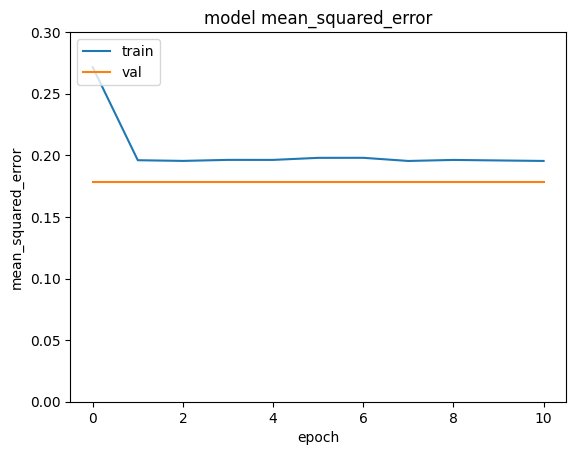

In [95]:
from matplotlib import pyplot as plt
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.ylim(0, 0.3)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_bot.load_weights(filepath = 'bot_model.hdf5')
y_res = model_bot.predict(X_valid)
y_res = [0 if x < 0 else x for x in y_res]
y_res = [1 if x > 1 else x for x in y_res]


score = mean_squared_error(y_valid, y_res)

#print(y_res)
#0.12134737364230679
'''

'''
print(score)

##### 2.2.4.2.4 RandomForest Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report


#best fit
#{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}


xg_bot = xgb.XGBClassifier(learning_rate=0.01,
                          max_depth=7,
                          colsample_bytree= 0.7,
                          min_child_weight= 5,
                          subsample= 0.7,
                          objective="reg:squarederror",
                          n_estimators=100)

xg_bot.fit(X_train, y_train)
y_pred = xg_bot.predict(X_valid)
y_pred_train = xg_bot.predict(X_train)

#xg_reg.feature_importances_
rms_train = mean_squared_error(y_train, y_pred_train)
rms_test = mean_squared_error(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
acc_score = accuracy_score(y_valid, y_pred)

print(f"Mean squared error for train set is {rms_train}")
print(f"Mean squared error for test set is {rms_test}")
print(f"Accuracy Score: {acc_score}")
print(classification_report(y_valid,y_pred))
xg_bot.feature_importances_

# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [174]:
dfPolitical.shape

(33533, 19)

In [177]:
print('{}evaluation-round{}-tweet.csv'.format(PATH_TO_DOWNLOADED,ROUND))

/Users/gorkemyar/Desktop/CS412/evaluation-round3-tweet.csv


In [196]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('{}evaluation-round{}-tweet.csv'.format(PATH_TO_DOWNLOADED,ROUND), dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# # define X as we did above in section (2.x.2. Separate X and y values)

X = dfPolitical_test[['text_length','num_mentions', 'user_description_political','num_political_entities'
                        ,'num_hashtags',  'total_interactions', 'name_numeric_character_count']]
# # make predictions based on these variables


In [179]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

text_political  = dfPolitical_test.apply(lambda x: x[['text']], axis=1)

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

# Compute embeddings.
text_result = embed(text_political)

In [180]:
text_result.shape

TensorShape([5000, 512])

In [181]:
def createDict(char,text_fields):
    text_map = dict()
    for i in range(len(text_fields[0])):
        text_map[char+ '_' + str(i)] = []
    for i in range(len(text_fields)):
        if (i % 100 == 0):
            print(i)
        for j in range(len(text_fields[i])):
            text_map[char+'_' + str(j)].append(text_fields[i][j].numpy())
    return text_map
test_political_text = createDict('text',text_result)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [197]:
df_test_text = pd.DataFrame(test_political_text)
df_test_text.shape
for i in df_test_text.columns:
    df_test_text.rename(columns={i: i.replace('text_','t_')}, inplace=True)

X = X.join(df_test_text)

X.head(10)

,text_length,num_mentions,user_description_political,num_political_entities,num_hashtags,total_interactions,name_numeric_character_count,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,t_40,t_41,t_42,t_43,t_44,t_45,t_46,t_47,t_48,t_49,t_50,t_51,t_52,t_53,t_54,t_55,t_56,t_57,t_58,t_59,t_60,t_61,t_62,t_63,t_64,t_65,t_66,t_67,t_68,t_69,t_70,t_71,t_72,t_73,t_74,t_75,t_76,t_77,t_78,t_79,t_80,t_81,t_82,t_83,t_84,t_85,t_86,t_87,t_88,t_89,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,t_100,t_101,t_102,t_103,t_104,t_105,t_106,t_107,t_108,t_109,t_110,t_111,t_112,t_113,t_114,t_115,t_116,t_117,t_118,t_119,t_120,t_121,t_122,t_123,t_124,t_125,t_126,t_127,t_128,t_129,t_130,t_131,t_132,t_133,t_134,t_135,t_136,t_137,t_138,t_139,t_140,t_141,t_142,t_143,t_144,t_145,t_146,t_147,t_148,t_149,t_150,t_151,t_152,t_153,t_154,t_155,t_156,t_157,t_158,t_159,t_160,t_161,t_162,t_163,t_164,t_165,t_166,t_167,t_168,t_169,t_170,t_171,t_172,t_173,t_174,t_175,t_176,t_177,t_178,t_179,t_180,t_181,t_182,t_183,t_184,t_185,t_186,t_187,t_188,t_189,t_190,t_191,t_192,t_193,t_194,t_195,t_196,t_197,t_198,t_199,t_200,t_201,t_202,t_203,t_204,t_205,t_206,t_207,t_208,t_209,t_210,t_211,t_212,t_213,t_214,t_215,t_216,t_217,t_218,t_219,t_220,t_221,t_222,t_223,t_224,t_225,t_226,t_227,t_228,t_229,t_230,t_231,t_232,t_233,t_234,t_235,t_236,t_237,t_238,t_239,t_240,t_241,t_242,t_243,t_244,t_245,t_246,t_247,t_248,t_249,t_250,t_251,t_252,t_253,t_254,t_255,t_256,t_257,t_258,t_259,t_260,t_261,t_262,t_263,t_264,t_265,t_266,t_267,t_268,t_269,t_270,t_271,t_272,t_273,t_274,t_275,t_276,t_277,t_278,t_279,t_280,t_281,t_282,t_283,t_284,t_285,t_286,t_287,t_288,t_289,t_290,t_291,t_292,t_293,t_294,t_295,t_296,t_297,t_298,t_299,t_300,t_301,t_302,t_303,t_304,t_305,t_306,t_307,t_308,t_309,t_310,t_311,t_312,t_313,t_314,t_315,t_316,t_317,t_318,t_319,t_320,t_321,t_322,t_323,t_324,t_325,t_326,t_327,t_328,t_329,t_330,t_331,t_332,t_333,t_334,t_335,t_336,t_337,t_338,t_339,t_340,t_341,t_342,t_343,t_344,t_345,t_346,t_347,t_348,t_349,t_350,t_351,t_352,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392,t_393,t_394,t_395,t_396,t_397,t_398,t_399,t_400,t_401,t_402,t_403,t_404,t_405,t_406,t_407,t_408,t_409,t_410,t_411,t_412,t_413,t_414,t_415,t_416,t_417,t_418,t_419,t_420,t_421,t_422,t_423,t_424,t_425,t_426,t_427,t_428,t_429,t_430,t_431,t_432,t_433,t_434,t_435,t_436,t_437,t_438,t_439,t_440,t_441,t_442,t_443,t_444,t_445,t_446,t_447,t_448,t_449,t_450,t_451,t_452,t_453,t_454,t_455,t_456,t_457,t_458,t_459,t_460,t_461,t_462,t_463,t_464,t_465,t_466,t_467,t_468,t_469,t_470,t_471,t_472,t_473,t_474,t_475,t_476,t_477,t_478,t_479,t_480,t_481,t_482,t_483,t_484,t_485,t_486,t_487,t_488,t_489,t_490,t_491,t_492,t_493,t_494,t_495,t_496,t_497,t_498,t_499,t_500,t_501,t_502,t_503,t_504,t_505,t_506,t_507,t_508,t_509,t_510,t_511
0,104,1,0,0,0,0,0,0.003596,0.021388,0.024883,0.038776,-0.045930,0.020258,0.030196,0.004659,-0.040191,-0.035678,-0.005405,0.018178,0.050025,0.084714,-0.071507,0.072908,0.049565,0.030927,-0.003762,0.040071,0.031896,0.024993,0.002292,0.021844,0.017159,0.023097,0.040341,-0.063067,0.027186,-0.014420,-0.055267,-0.037476,0.001163,-0.040734,-0.074303,-0.043970,0.048908,0.069995,0.014935,0.090338,-0.024893,-0.048810,0.074224,0.019923,-0.024774,0.080301,0.055973,0.003312,-0.016092,0.035025,-0.037716,0.023443,0.033723,-0.056200,0.003254,-0.014775,0.038590,0.031529,-0.021124,-0.004015,0.062855,0.027200,-0.028057,0.021001,0.098826,-0.028625,-0.012636,-0.056264,-0.034207,0.026091,-0.087446,-0.002390,0.008370,-0.092598,0.000300,-0.032248,-0.024596,0.030388,0.003239,-0.069253,-0.103875,-0.055389,0.010477,0.039699,0.034257,-0.052939,-0.002423,0.079753,-0.034371,-0.020810,0.009858,-0.021079,-0.046691,-0.03

In [198]:
print(X.shape)

(5000, 519)


In [202]:
model_political.load_weights(filepath = 'political_best.hdf5')
predictions_political = model_political.predict(X)

157/157 [==============================] - 0s 1ms/step


### This part is important! We expect you to return your predictions in the following format:

In [203]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
#modelPredTweet

## 3.2. Predictions for Users (Bot or Not)

In [224]:
evaluationUserDf = pd.read_csv('{}evaluation-round{}-user.csv'.format(PATH_TO_DOWNLOADED,ROUND), dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfBot_test[['retweet_total_ratio',  'user_average_tweet_day', 'user_tweet_count',
                    'unique_tweet_ratio', 'user_followers_count', 'user_friends_count', 
                    'hashtag_ratio',  'tweet_len_ratio']]
# make predictions based on these variables

In [212]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

description = dfBot_test.apply(lambda x: x[['user_description']], axis=1)

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

# Compute embeddings.
description_bot_result = embed(description)

In [206]:
description_bot_result.shape

TensorShape([4999, 512])

In [207]:
def createDict(char,text_fields):
    text_map = dict()
    for i in range(len(text_fields[0])):
        text_map[char+ '_' + str(i)] = []
    for i in range(len(text_fields)):
        if (i % 100 == 0):
            print(i)
        for j in range(len(text_fields[i])):
            text_map[char+'_' + str(j)].append(text_fields[i][j].numpy())
    return text_map
description_bot_dict = createDict('description',description_bot_result)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [225]:
df_test_description = pd.DataFrame(description_bot_dict)
for i in df_test_description.columns:
    df_test_description.rename(columns={i: i.replace('description_','d_')}, inplace=True)
X = X.join(df_test_description)
print(X.isna().sum())
for col in X.columns:
    X[col] = X[col].fillna(X[col].mean())

X.head(10)

retweet_total_ratio       134
user_average_tweet_day      0
user_tweet_count            0
unique_tweet_ratio        120
user_followers_count        0
                         ... 
d_507                       0
d_508                       0
d_509                       0
d_510                       0
d_511                       0
Length: 520, dtype: int64


,retweet_total_ratio,user_average_tweet_day,user_tweet_count,unique_tweet_ratio,user_followers_count,user_friends_count,hashtag_ratio,tweet_len_ratio,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511
0,0.659898,0.487579,1629,1.000000,100,98,0.446701,119.421320,0.091170,0.029737,0.043944,0.050024,0.028386,0.020979,0.027484,-0.026615,0.005766,0.025703,-0.016711,0.011460,-0.075977,-0.037786,-0.058849,0.060701,0.016963,0.032930,0.043804,-0.021934,0.074286,0.022045,0.040034,-0.049679,-0.030526,0.077159,0.017548,-0.005177,0.086015,0.018414,0.044567,0.015124,-0.062099,-0.038421,-0.063434,-0.022710,0.046322,-0.035035,0.060866,0.021463,-0.052568,0.070141,0.071401,0.047074,-0.044258,-0.050752,0.012975,-0.013157,-0.032029,0.080923,0.019304,-0.060133,-0.060368,0.015631,-0.034962,-0.067845,0.027008,0.044476,-0.066779,-0.021521,-0.017901,-0.036405,-0.068924,0.002382,0.040783,0.054556,-0.070045,0.018249,0.013772,-0.004467,-0.003432,0.066078,-0.038843,-0.022425,0.066261,-0.054035,-0.005596,0.084086,-0.057323,0.091424,-0.077244,-0.014610,-0.026982,-0.006739,0.006259,0.049966,0.019007,0.05

In [226]:
predictions_bot = ensemble_model_bot.predict(X)

In [227]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
#modelPredUser

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [228]:
# Explain your approach

data_explanations = '''
As a group, we combined our data with the data that given to us. After this we used this combined data to train our model. However, since there are some errors in our annotation our data did not give good results. Therefore we did not use it. As usual, we used 
80% of the data for the training and 20% for the validation.  
'''

feature_explanations = '''
We generated the following features for our political model:
text_length: The length of the tweet
num_mentions: The number of mentions in the tweet
user_description_political: The political entities in the user description
num_political_entities: The number of political entities in the tweet
num_hashtags: The number of hashtags in the tweet
total_interactions: The total number of interactions in the tweet
name_numeric_character_count: The number of numeric characters in the user name

Also, with tensorflow hub, we used the universal sentence encoder to generate 512 features for the text of the tweet.

We combined these features to generate a model.

For the bot model, we generated the following features:
retweet_total_ratio: The ratio of retweets to total tweets
user_average_tweet_day: The average number of tweets per day
user_tweet_count: The number of tweets of the user
unique_tweet_ratio: The ratio of unique tweets to total tweets
user_followers_count: The number of followers of the user
user_friends_count: The number of friends of the user
hashtag_ratio: The number of hashtags to total tweets
tweet_len_ratio: The average length of the tweets of the user

Also, with tensorflow hub, we used the universal sentence encoder to generate 512 features for the description of the user.

We combined these features to generate a model.
'''

model_explanations = '''

For the political prediction model, we used the Neural Network model. We saved best results given epoch and used it for the prediction. Also we used the following parameters:
learning_rate=0.01
epochs=100
batch_size=8

We used 4 Dense layers with 32, 16, 8, 1 neurons respectively. Also, we used the following activation functions, relu, relu, relu, sigmoid respectively. Also there are some dropout layers to prevent overfitting.


For the bot prediction model, we used the AdaBoost model. We used the following parameters:
n_estimators=100
learning_rate=0.005

Unfortunately, NN model did not give good results. Therefore we used AdaBoost model. 
'''

additional_explanations = '''
Also, we used oversampling in tweet data to adjust the class distribution of our data set. 
'''


In [229]:
predictions = {
    'round': ROUND,
    'student_id': STUDENT_ID,
    'user_predictions': modelPredUser,
    'tweet_predictions': modelPredTweet,
    'explanations': {
        'data': data_explanations,
        'feature': feature_explanations,
        'model': model_explanations,
        'other': additional_explanations,
    }
}


with open('predictions-{}_round{}.json'.format(STUDENT_ID, ROUND), 'w') as fl:
    fl.write(json.dumps(predictions, indent=4))

In [ ]:
# Test your submission file

submission = json.load(open('predictions-{}_round{}.json'.format(STUDENT_ID, ROUND), 'r'))
#submission